In [18]:
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet 
import argparse
import numpy as np     
import matplotlib.pyplot as plt

In [19]:
# Check if cuda is available
use_cuda = torch.cuda.is_available()

# Set proper device based on cuda availability 
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

# Create transformations to apply to each data sample 
# Can specify variations such as image flip, color flip, random crop, ...
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Load datasets for training and testing
# Inbuilt datasets available in torchvision (check documentation online)
dataset1 = datasets.MNIST('./data/', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('./data/', train=False,
                    transform=transform)

Torch device selected:  cpu


In [40]:
def load_data(batch_size=10, num_workers=4):
    train_loader = DataLoader(dataset1, batch_size = batch_size, 
                            shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = batch_size, 
                                shuffle=False, num_workers=4)
    
    return train_loader, test_loader

def plot(num_epochs, train_losses, train_accuracies, save=0, mode=1):
    x = range(1, num_epochs+1)

    plt.plot(x, train_losses)
    plt.plot(x, train_accuracies)
    plt.legend(['Train Loss', 'Train Accuracy'])
    
    if save:
        plt.savefig(f'plots/model_{mode}.jpg')
        plt.show()

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size, num_epochs):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target 
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    
    # Set model to train mode before each epoch
    model.train()
    
    # Empty list to store losses 
    losses = []
    correct = 0
    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample
        # print(f'{data.shape = }')
        
        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        
        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()
        
        # Do forward pass for current set of data
        output = model(data)
        # Compute loss based on criterion
        loss = criterion(output, target)
        
        # Computes gradient based on final loss
        loss.backward()
        
        # Store loss
        losses.append(loss.item())
        
        # Optimize model parameters based on learning rate and gradient 
        optimizer.step()
        
        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)
        
        _, predictions = output.max(1)
        correct += (predictions == target).sum()
        print(f'Training epoch: ({epoch}/{num_epochs}) batch: ({batch_idx+1}/{len(train_loader)})', end='\r') #. Acc: {correct}/{(batch_idx+1) * batch_size}, {100. * correct / ((batch_idx+1) * batch_size)}', end='\r')
        
    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('\nTrain set ({}/{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, num_epochs,
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc
    
def test(model, device, test_loader, criterion, epoch, num_epochs, batch_size):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)
            # Predict for data by doing forward pass
            output = model(data)
        
            # Compute loss based on same criterion as training 
            loss = criterion(output, target)
            
            # Append loss to overall test loss
            losses.append(loss.item())
            
            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)
            
            _, predictions = output.max(1)
            correct += (predictions == target).sum()
            print(f'Testing epoch: ({epoch}/{num_epochs}) batch: ({batch_idx+1}/{len(test_loader)})', end='\r')

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set ({}/{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, num_epochs,
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy


In [41]:
def run_model(mode=1, learning_rate=0.01, batch_size=10, num_epochs=60):
    image_size = 28*28
    num_classes = 10

    # Initialize the model and send to device 
    model = ConvNet(mode, image_size, num_classes).to(device)
    # Define loss function.
    criterion = nn.CrossEntropyLoss()
    # Define optimizer function.
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    # Define data loaders
    train_loader, test_loader = load_data(batch_size)

    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []
    # Run training for n_epochs specified in config 
    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, batch_size, num_epochs)
        test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch, num_epochs, batch_size)
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.cpu().numpy())

    plot(num_epochs, train_losses, train_accuracies, save=1, mode=mode)

    print("Accuracy: {:2.2f}%".format(best_accuracy))

    print("Training and evaluation finished")

Training epoch: (1/5) batch: (6000/6000)
Train set (1/5): Average loss: 0.6031, Accuracy: 51494/60000 (86%)

Testing epoch: (1/5) batch: (1000/1000)
Test set (1/5): Average loss: 0.3139, Accuracy: 9132/10000 (91%)

Training epoch: (2/5) batch: (6000/6000)
Train set (2/5): Average loss: 0.2895, Accuracy: 55125/60000 (92%)

Testing epoch: (2/5) batch: (1000/1000)
Test set (2/5): Average loss: 0.2535, Accuracy: 9287/10000 (93%)

Training epoch: (3/5) batch: (6000/6000)
Train set (3/5): Average loss: 0.2411, Accuracy: 55874/60000 (93%)

Testing epoch: (3/5) batch: (1000/1000)
Test set (3/5): Average loss: 0.2221, Accuracy: 9366/10000 (94%)

Training epoch: (4/5) batch: (6000/6000)
Train set (4/5): Average loss: 0.2096, Accuracy: 56390/60000 (94%)

Testing epoch: (4/5) batch: (1000/1000)
Test set (4/5): Average loss: 0.1974, Accuracy: 9424/10000 (94%)

Training epoch: (5/5) batch: (6000/6000)
Train set (5/5): Average loss: 0.1863, Accuracy: 56845/60000 (95%)

Testing epoch: (5/5) batch: (10

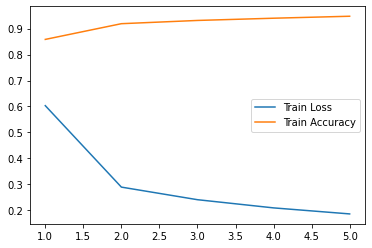

accuracy is 94.64
Training and evaluation finished


In [42]:
# Model 1
learning_rate = 0.01
batch_size = 10
# num_epochs = 60
num_epochs = 5

run_model(mode=1, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)

In [44]:
# Model 2
learning_rate = 0.01
batch_size = 10
num_epochs = 60
num_epochs = 5

run_model(mode=2, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)

Training epoch: (1/5) batch: (6000/6000)
Train set (1/5): Average loss: 0.9695, Accuracy: 41520/60000 (69%)

Testing epoch: (1/5) batch: (1000/1000)
Test set (1/5): Average loss: 0.2948, Accuracy: 9175/10000 (92%)



KeyboardInterrupt: 

In [6]:
# Model 3
learning_rate = 0.03
batch_size = 10
num_epochs = 60

run_model(mode=3, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)

KeyboardInterrupt: 

In [5]:
# Model 4
learning_rate = 0.03
batch_size = 10
num_epochs = 60

run_model(mode=4, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)

KeyboardInterrupt: 

In [5]:
# Model 5
learning_rate = 0.03
batch_size = 10
num_epochs = 40

run_model(mode=5, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)

KeyboardInterrupt: 